## Hidden layer

This part will cover:
* Hidden layers
* [Non-linear transfer functions](http://peterroelants.github.io/posts/neural_network_implementation_part03/#Non-linear-transfer-function)
* [Backpropagation](http://peterroelants.github.io/posts/neural_network_implementation_part03/#Optimization-by-backpropagation)

While the previous tutorials described very simple single layer regression and classification models, this tutorial will describe a 2-class classification neural network with 1 input dimension, and a non-linear hidden layer with 1 neuron. This network can be represented graphically as:

![Image of the logistic model](https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/neural_net_implementation/img/SimpleANN03.png)

The notebook starts out with importing the libraries we need:

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
from matplotlib import cm # Colormaps
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

## Define the dataset 

In this example the target classes $t$ corresponding to the inputs $x$ will be generated from 2 class distributions: blue ($t=1$) and red ($t=0$). Where the red class is a [multimodal distribution](http://en.wikipedia.org/wiki/Multimodal_distribution) that surrounds the distribution of the blue class. This results in a 1D dataset that is not linearly separable. These samples are plotted in the figure below. 

The model from part 2 won't be able to classify both classes correctly since it can learn only linear separators. By adding a hidden layer with a non-linear transfer function, the model will be able to train a non-linear classifier.

In [2]:
# Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
blue_mean = [0]  # The mean of the blue class
red_left_mean = [-2]  # The mean of the red class
red_right_mean = [2]  # The mean of the red class

std_dev = 0.5  # standard deviation of both classes
# Generate samples from both classes
x_blue = np.random.randn(nb_of_samples_per_class, 1) * std_dev + blue_mean
x_red_left = np.random.randn(nb_of_samples_per_class/2, 1) * std_dev + red_left_mean
x_red_right = np.random.randn(nb_of_samples_per_class/2, 1) * std_dev + red_right_mean

# Merge samples in set of input variables x, and corresponding set of
# output variables t
x = np.vstack((x_blue, x_red_left, x_red_right))
t = np.vstack((np.ones((x_blue.shape[0],1)), 
               np.zeros((x_red_left.shape[0],1)), 
               np.zeros((x_red_right.shape[0], 1))))

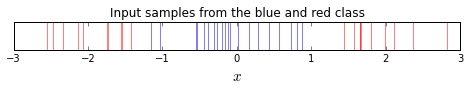

In [3]:
# Plot samples from both classes as lines on a 1D space
plt.figure(figsize=(8,0.5))
plt.xlim(-3,3)
plt.ylim(-1,1)
# Plot samples
plt.plot(x_blue, np.zeros_like(x_blue), 'b|', ms = 30) 
plt.plot(x_red_left, np.zeros_like(x_red_left), 'r|', ms = 30) 
plt.plot(x_red_right, np.zeros_like(x_red_right), 'r|', ms = 30) 
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples from the blue and red class')
plt.xlabel('$x$', fontsize=15)
plt.show()

## Non-linear transfer function 

The non-linear transfer function used in the hidden layer of this example is the [Gaussian](http://en.wikipedia.org/wiki/Gaussian_function) [radial basis function](http://en.wikipedia.org/wiki/Radial_basis_function) (RBF).  
The RBF is a transfer function that is not usually used in neural networks, except for [radial basis function networks](http://en.wikipedia.org/wiki/Radial_basis_function_network). One of the most common transfer functions in neural networks is the [sigmoid](http://en.wikipedia.org/wiki/Sigmoid_function) transfer function.
The RBF will allow to separate the blue samples from the red samples in this simple example by only activating for a certain region around the origin. The RBF is plotted in the figure below and is defined in this example as:

$$ \text{RBF} = \phi(z) = e^{-z^2} $$

The derivative of this RBF function is:

$$ \frac{d \phi(z)}{dz} = -2 z e^{-z^2} = -2 z \phi(z)$$

In [4]:
# Define the rbf function
def rbf(z):
    return np.exp(-z**2)

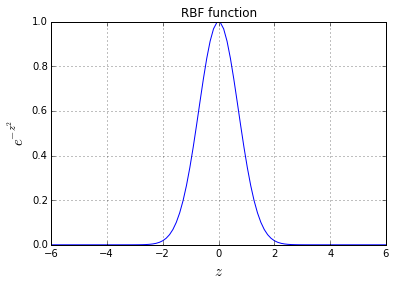

In [5]:
# Plot the rbf function
z = np.linspace(-6,6,100)
plt.plot(z, rbf(z), 'b-')
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$e^{-z^2}$', fontsize=15)
plt.title('RBF function')
plt.grid()
plt.show()

## Optimization by backpropagation

We will train this model by using the [backpropagation](http://en.wikipedia.org/wiki/Backpropagation) algorithm that is typically used to train neural networks. Each iteration of the backpropagation algorithm consists of two steps:

1. A forward propagation step to compute the output of the network.
2. A backward propagation step in which the error at the end of the network is propagated backward through all the neurons while updating their parameters.

### 1. Forward step

During the forward step, the input will be propagated layer by layer through the network to compute the final output of the network.

#### Compute activations of hidden layer

The activations $\mathbf{h}$ of the hidden layer will be computed by:

$$\mathbf{h} = \phi(\mathbf{x}*w_h) = e^{-(\mathbf{x}*w_h)^2} $$

With $w_h$ the weight parameter that transforms the input before applying the RBF transfer function. This is implemented below by the `hidden_activations(x, wh)` method.

#### Compute activations of output 

The output of the final layer and network will be computed by passing the hidden activations $\mathbf{h}$ as input to the logistic output function:

$$ \mathbf{y} = \sigma(\mathbf{h} * w_o - 1) = \frac{1}{1+e^{-\mathbf{h} * w_o - 1}} $$

With $w_o$ the weight parameter of the output layer. This is implemented below as the `output_activations(h , wo)` method.
Note that we add a bias (intercept) term of $-1$ to the input of the logistic output neuron. Remember from part 2 that the logistic output neuron without bias can only learn a decision boundary that goes through the origin $(0)$. Since the RBF in the hidden layer projects all input variables to a range between $0$ and $1$, the output layer without an intercept will not be able to learn any useful classifier, because none of the samples will be below $0$ and thus lie on the left side of the decision boundary. By adding a bias term the decision boundary is moved from the intercept. Normally the value of this bias term is learned together with the rest of the weight parameters, but to keep this model simple we just make this bias constant in this example. [(More details on this here.)](http://stackoverflow.com/a/42436987/919431)

In [6]:
# Define the logistic function
def logistic(z): 
    return 1 / (1 + np.exp(-z))

# Function to compute the hidden activations
def hidden_activations(x, wh):
    return rbf(x * wh)

# Define output layer feedforward
def output_activations(h , wo):
    return logistic(h * wo - 1)

# Define the neural network function
def nn(x, wh, wo): 
    return output_activations(hidden_activations(x, wh), wo)

# Define the neural network prediction function that only returns
#  1 or 0 depending on the predicted class
def nn_predict(x, wh, wo): 
    return np.around(nn(x, wh, wo))

### 2. Backward step

The backward step will begin with computing the cost at the output node. This cost will then be propagated backwards layer by layer through the network to update the parameters.

The [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) algorithm is used in every layer to update the parameters in the direction of the negative [gradient](http://en.wikipedia.org/wiki/Gradient).

The parameters $w_h$ and $w_o$ are updated by $w(k+1) = w(k) - \Delta w(k+1)$. $\Delta w$ is defined as: $\Delta w = \mu * {\partial \xi}/{\partial w}$ with $\mu$ the learning rate and ${\partial \xi}/{\partial w}$ the gradient of the parameter $w$ with respect to the cost function $\xi$.

#### Compute the cost function

The cost function $\xi$ used in this model is the same cross-entropy cost function explained in [intermezzo 1]({% post_url 2015-06-10-neural_network_implementation_intermezzo01 %}):

$$\xi(t_i,y_i) = - \left[ t_i log(y_i) + (1-t_i)log(1-y_i) \right]$$

This cost function is plotted for the $w_h$ and $w_o$ parameters in the next figure. Note that this error surface is not convex anymore and that the $w_h$ parameter mirrors the cost function along the $w_h = 0$ axis.  
Also, notice that this cost function has a very sharp gradient around $w_h = 0$ starting from $w_o > 0$ and that the minima run along the lower edge of this peak. If the learning rate will be to big, the updates might jump over the minima gap, onto the sharp gradient. Because the gradient is sharp, the update will be large, and we might end up further from the minima than we started.

In [7]:
# Define the cost function
def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

# Define a function to calculate the cost for a given set of parameters
def cost_for_param(x, wh, wo, t):
    return cost(nn(x, wh, wo) , t)

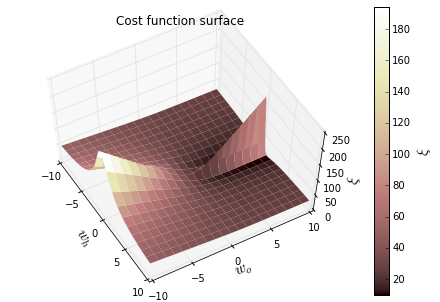

In [8]:
# Plot the cost in function of the weights
# Define a vector of weights for which we want to plot the cost
nb_of_ws = 200 # compute the cost nb_of_ws times in each dimension
wsh = np.linspace(-10, 10, num=nb_of_ws) # hidden weights
wso = np.linspace(-10, 10, num=nb_of_ws) # output weights
ws_x, ws_y = np.meshgrid(wsh, wso) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize cost matrix
# Fill the cost matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        cost_ws[i,j] = cost(nn(x, ws_x[i,j], ws_y[i,j]) , t)
# Plot the cost function surface
fig = plt.figure()
ax = Axes3D(fig)
# plot the surface
surf = ax.plot_surface(ws_x, ws_y, cost_ws, linewidth=0, cmap=cm.pink)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
ax.set_xlabel('$w_h$', fontsize=15)
ax.set_ylabel('$w_o$', fontsize=15)
ax.set_zlabel('$\\xi$', fontsize=15)
cbar.ax.set_ylabel('$\\xi$', fontsize=15)
plt.title('Cost function surface')
plt.grid()
plt.show()

#### Update the output layer

At the output the gradient for sample $i$, ${\partial \xi_i}/{\partial w_o}$, can be worked out the same way as we did in [part 2]({% post_url 2015-06-10-neural_network_implementation_part02 %}):

$$\frac{\partial \xi_i}{\partial w_o} = \frac{\partial z_{oi}}{\partial w_o} \frac{\partial y_i}{\partial z_{oi}} \frac{\partial \xi_i}{\partial y_i} = h_i (y_i-t_i) = h_i * \delta_{oi}$$

With $z_{oi} = h_i * w_o$, $h_i$ the hidden layer activation of sample $i$ and ${\partial \xi_i}/{\partial z_{oi}} = \delta_{oi}$ the gradient of the error at the output layer of the neural network with respect to the input to this layer.


$\delta_{o}$ is defined below as the `gradient_output(y, t)` method and ${\partial \xi}/{\partial w_o}$ as the `gradient_weight_out(h, grad_output)` method.


#### Update the hidden layer

At the hidden layer the gradient for sample $i$, ${\partial \xi_i}/{\partial w_{h}}$, of the hidden neuron is computed the same way:

$$\frac{\partial \xi_i}{\partial w_{h}} = \frac{\partial z_{hi}}{\partial w_{h}} \frac{\partial h_i}{\partial z_{hi}} \frac{\partial \xi_i}{\partial h_i}$$

With $z_{hi} = x_i * w_{h} $. And with ${\partial \xi_i}/{\partial z_{hi}} = \delta_{hi}$ the gradient of the error at the input of the hidden layer with respect to the input to this layer. This error can be interpreted as the contribution of $z_{hi}$ to the final error.
How do we define this error gradient $\delta_{hi}$ at the input of the hidden neurons? It can be computed as the error gradient propagated back from the output layer through the hidden layer.

$$\delta_{hi} = \frac{\partial \xi_i}{\partial z_{hi}} = \frac{\partial h_i}{\partial z_{hi}} \frac{\partial z_{oi}}{\partial h_i} \frac{\partial \xi_i}{\partial z_{oi}} 
= (-2 * z_{hi} * h_i) * w_{o} * (y_i - t_i) = -2 * z_{hi} * h_i * w_{o} * \delta_{oi} $$

Because of this, and because ${\partial z_{hi}}/{\partial w_{h}} = x_i$ we can compute ${\partial \xi_i}/{\partial w_{h}}$ as:

$$\frac{\partial \xi_i}{\partial w_{h}} = x_i \delta_{hi}  $$

The gradients for each parameter can again be summed up to compute the update for a batch of input examples.

$\delta_{h}$ is defined below as the `gradient_hidden(wo, grad_output)` method and ${\partial \xi}/{\partial w_h}$ as the `gradient_weight_hidden(x, zh, h, grad_hidden)` method.

To start out the gradient descent algorithm, you typically start with picking the initial parameters at random and start updating these parameters in the direction of the negative gradient with help of the backpropagation algorithm. One backpropagation iteration is implemented below by the `backprop_update(x, t, wh, wo, learning_rate)` method.

In [9]:
# Define the error function
def gradient_output(y, t):
    return y - t

# Define the gradient function for the weight parameter at the output layer
def gradient_weight_out(h, grad_output): 
    return  h * grad_output

# Define the gradient function for the hidden layer
def gradient_hidden(wo, grad_output):
    return wo * grad_output

# Define the gradient function for the weight parameter at the hidden layer
def gradient_weight_hidden(x, zh, h, grad_hidden):
    return x * -2 * zh * h * grad_hidden

# Define the update function to update the network parameters over 1 iteration
def backprop_update(x, t, wh, wo, learning_rate):
    # Compute the output of the network
    # This can be done with y = nn(x, wh, wo), but we need the intermediate 
    #  h and zh for the weight updates.
    zh = x * wh
    h = rbf(zh)  # hidden_activations(x, wh)
    y = output_activations(h, wo)
    # Compute the gradient at the output
    grad_output = gradient_output(y, t)
    # Get the delta for wo
    d_wo = learning_rate * gradient_weight_out(h, grad_output)
    # Compute the gradient at the hidden layer
    grad_hidden = gradient_hidden(wo, grad_output)
    # Get the delta for wh
    d_wh = learning_rate * gradient_weight_hidden(x, zh, h, grad_hidden)
    # return the update parameters
    return (wh-d_wh.sum(), wo-d_wo.sum())

### Backpropagation updates

An example run of backpropagation for 50 iterations on the example inputs $\mathbf{x}$ and targets $\mathbf{t}$ is shown in the figure below. The white dots represent the weight parameter values $w_h$ and $w_o$ at iteration $k$ and are plotted on the cost surface.

Notice that we decrease the learning rate linearly with each step. This is to make sure that in the end the learning rate is 0 and the sharp gradient will not allow the weight paramaters to fluctuate much during the last few iterations.

In [10]:
# Run backpropagation
# Set the initial weight parameter
wh = 2
wo = -5
# Set the learning rate
learning_rate = 0.2

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 50  # number of gradient descent updates
lr_update = learning_rate / nb_of_iterations # learning rate update rule
w_cost_iter = [(wh, wo, cost_for_param(x, wh, wo, t))]  # List to store the weight values over the iterations
for i in range(nb_of_iterations):
    learning_rate -= lr_update # decrease the learning rate
    # Update the weights via backpropagation
    wh, wo = backprop_update(x, t, wh, wo, learning_rate) 
    w_cost_iter.append((wh, wo, cost_for_param(x, wh, wo, t)))  # Store the values for plotting

# Print the final cost
print('final cost is {:.2f} for weights wh: {:.2f} and wo: {:.2f}'.format(cost_for_param(x, wh, wo, t), wh, wo))

final cost is 9.55 for weights wh: 1.07 and wo: 5.05


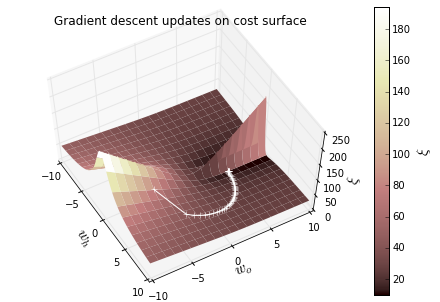

In [11]:
# Plot the weight updates on the error surface
# Plot the error surface
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(ws_x, ws_y, cost_ws, linewidth=0, cmap=cm.pink)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('$\\xi$', fontsize=15)

# Plot the updates
for i in range(1, len(w_cost_iter)):
    wh1, wo1, c1 = w_cost_iter[i-1]
    wh2, wo2, c2 = w_cost_iter[i]
    # Plot the weight-cost value and the line that represents the update 
    ax.plot([wh1], [wo1], [c1], 'w+')  # Plot the weight cost value
    ax.plot([wh1, wh2], [wo1, wo2], [c1, c2], 'w-')
# Plot the last weights
wh1, wo1, c1 = w_cost_iter[len(w_cost_iter)-1]
ax.plot([wh1], [wo1], c1, 'w+')
# Shoz figure
ax.set_xlabel('$w_h$', fontsize=15)
ax.set_ylabel('$w_o$', fontsize=15)
ax.set_zlabel('$\\xi$', fontsize=15)
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

## Visualization of the trained classifier


The resulting decision boundary of running backpropagation on the example inputs $\mathbf{x}$ and targets $\mathbf{t}$ is shown in the figure below. The background color (blue, red) refers to the classification decision of the trained classifier at that position in the input space. Note that all examples are classified correctly by the trained classifier.

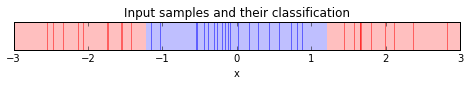

In [12]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xs = np.linspace(-3, 3, num=nb_of_xs)
ys = np.linspace(-1, 1, num=nb_of_xs)
xx, yy = np.meshgrid(xs, ys) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        classification_plane[i,j] = nn_predict(xx[i,j], wh, wo)
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.25),
        colorConverter.to_rgba('b', alpha=0.25)])

# Plot the classification plane with decision boundary and input samples
plt.figure(figsize=(8,0.5))
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.xlim(-3,3)
plt.ylim(-1,1)
# Plot samples from both classes as lines on a 1D space
plt.plot(x_blue, np.zeros_like(x_blue), 'b|', ms = 30) 
plt.plot(x_red_left, np.zeros_like(x_red_left), 'r|', ms = 30) 
plt.plot(x_red_right, np.zeros_like(x_red_right), 'r|', ms = 30) 
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples and their classification')
plt.xlabel('x')
plt.show()

## Transformation of the input domain

How is the neural network able to separate the non-linearly seperable classes with a linear logistic classifier at the output?  The key is the hidden layer with the non-linear RBF transfer function. Note that the RBF transfer function is able to transform the samples near the origin (blue class) to a value larger than $0$, and the samples further from the origin (red samples) to a value near $0$. This projection is plotted in the following figure. Note that the red samples are located around $0$ to the left, and that the blue samples are located more to the right. This projection is linearly seperable by the logistic classifier in the output layer.

Also, note that the offset of the peak of the Gaussian function we use is $0$. This means that the Gaussian function is centered around the origin, which can be noted in the symmetrical decision boundaries around the origin on the previous figure.


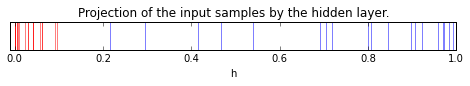

In [13]:
# Plot projected samples from both classes as lines on a 1D space
plt.figure(figsize=(8,0.5))
plt.xlim(-0.01,1)
plt.ylim(-1,1)
# Plot projected samples
plt.plot(hidden_activations(x_blue, wh), np.zeros_like(x_blue), 'b|', ms = 30) 
plt.plot(hidden_activations(x_red_left, wh), np.zeros_like(x_red_left), 'r|', ms = 30) 
plt.plot(hidden_activations(x_red_right, wh), np.zeros_like(x_red_right), 'r|', ms = 30) 
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Projection of the input samples by the hidden layer.')
plt.xlabel('h')
plt.show()

This post at [peterroelants.github.io](http://peterroelants.github.io/posts/neural_network_implementation_part03/) is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural_network_implementation_part03.ipynb)